In [36]:
import sys
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from astropy.visualization import astropy_mpl_style, quantity_support
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from os.path import join
sys.path.append('../lib')
from visibility import *
plt.style.use(astropy_mpl_style)
quantity_support()

# add catalog folder
catalog = 'path/to/your/catalog_folder'
# add table file
table = 'path/to/your/visibility_table.npy'

# grb template name
grb = 'Event3'
# site (check independently north and south!!!)
site = 'North'

# check data from table to compare later with independent results
data = np.load(table, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
data[grb]['South'], data[grb]['North']

({'start': array([2471611.58105254]),
  'stop': array([2471611.7705497]),
  'zref': array([60])},
 {'start': array([2471611.31856561, 2471611.40995245, 2471611.48248896,
         2471611.69510889]),
  'stop': array([2471611.40995245, 2471611.48248896, 2471611.69510889,
         2471611.7705497 ]),
  'zref': array([60, 40, 20, 40])})

In [37]:
# initialise template quantities
filename = join(catalog, grb+'.fits')
with fits.open(filename) as hdul:
    hdr = hdul[0].header
    source_radec = SkyCoord(ra=hdr['RA'] * u.deg, dec=hdr['DEC'] * u.deg, frame='icrs')  # source coordinates
    t_trigger = Time(hdr['GRBJD'] * u.day, format='jd')
    visibility_table = Table.read(hdul, hdu=1)  # visibility table
    times = np.array(hdul['TIMES (AFTERGLOW)'].data.tolist())
    
# event total duration
afterglow_duration = Time(((times[-1] + times[1]) / 2)[0] / 86400, format='jd')
# time windows [THIS SHOULD BE CHANGED ACCORDING TO THE TEMPLATE FORMAT]
t = [Time(visibility_table['True'].data, format='jd')]  # Doesn't have more >1 visibility window to test
t_true = []
for row in t:
    t_true.append(row[0:2])
# minimum altitude
min_altitude = visibility_table.meta['MIN_ALT'] * u.deg
# set IRF altitude thresholds
thresholds = tuple(sorted([min_altitude.value, 36, 57]))  # zenith 80 - 54 - 33 - 0
# set IRF reference zenith angles
zenith_angles = tuple(sorted([20, 40, 60], reverse=True))

print('ok')

ok



Event full duration
nights: {'start': array([2471611.31856537]), 'stop': array([2471611.77054946])}
Night 1 of 1
IRFs {'start': array([2471611.31856537, 2471611.41008451, 2471611.48242147,
       2471611.69514529]), 'stop': array([2471611.41008451, 2471611.48242147, 2471611.69514529,
       2471611.77054946]), 'zref': ['North_z60_0.5h', 'North_z40_0.5h', 'North_z20_0.5h', 'North_z40_0.5h']}


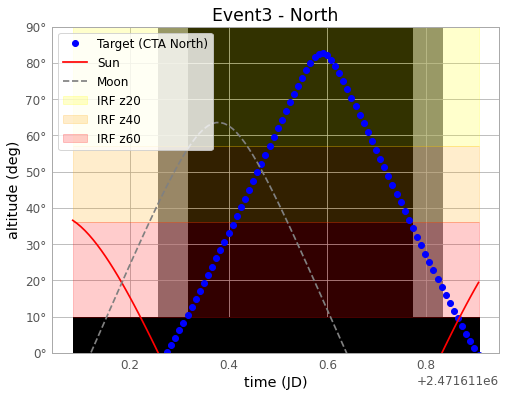

In [38]:
if_moon = True
if_markers = False
twilight = -18

sites = {'North': 'Roque de los Muchachos', 'South': 'Paranal'}
# initialise site coordinates
north_site_coords = EarthLocation.of_site(sites['North'])
south_site_coords = EarthLocation.of_site(sites['South'])
if site == 'North':
    site_coords = north_site_coords
else:
    site_coords = south_site_coords

# initialise visibility
t_start = t_trigger
#duration = Time(2, format='jd')  
duration = afterglow_duration
total_points = 100
night_points = 10

# ignore warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    print('\nEvent full duration')
    # initialise
    visibility = Visibility()
    # visibility points in JD and AltAz
    visibility.visibility_points(t_start, duration, total_points)
    visibility.visibility_altaz(source_radec, sites[site])
    # find nights
    nights_twilight = visibility.get_nighttime(0)
    nights_astronomical = visibility.get_nighttime(-18)
    nights = visibility.get_nighttime(twilight=twilight)
    print('nights:', nights)
    # plot source
    plt.plot(visibility.vis_points.value, visibility.altaz.alt.value, 'bo', label='Target (CTA %s)' % site)
    # plot min altitude
    plt.fill_between(visibility.vis_points.value, 0, min_altitude.value, color='k', zorder=1)
    # plot sun
    plt.plot(visibility.vis_points.value, visibility.sun_altaz.alt.value, color='r', label='Sun')
    # plot moon
    if if_moon:
        visibility.moon_position()
        plt.plot(visibility.vis_points.value, visibility.moon_altaz.alt, color='gray', ls='--', label='Moon')
    # plot irf
    plt.fill_between(visibility.vis_points.value, thresholds[2], 90, color='yellow', alpha=0.2, label='IRF z20')
    plt.fill_between(visibility.vis_points.value, thresholds[1], thresholds[2], color='orange', alpha=0.2, label='IRF z40')
    plt.fill_between(visibility.vis_points.value, thresholds[0], thresholds[1], color='red', alpha=0.2, label='IRF z60')
    # clear
    del visibility

    # within each night find IRFs
    for i in range(len(nights['start'])):
        print('Night', i+1, 'of', len(nights['start']))
        # plot nights
        plt.fill_between([nights_twilight['start'][i], nights_twilight['stop'][i]], 0, 90, color='0.5', zorder=0)
        if len(nights_astronomical['start']) > i:
            plt.fill_between([nights_astronomical['start'][i], nights_astronomical['stop'][i]], 0, 90, color='k', zorder=0)
        # initialise night visibility
        t_start = Time(nights['start'][i], format='jd')
        duration = Time(nights['stop'][i] - nights['start'][i], format='jd')
        visibility = Visibility()
        # visibility points in JD and AltAz
        visibility.visibility_points(t_start, duration, total_points)
        visibility.visibility_altaz(source_radec, sites[site])
        # IRFs and relative time intervals
        irfs = visibility.associate_irf_zenith_angle(thresholds, zenith_angles)
        # plot irf intervals
        if if_markers:
            for j, z in enumerate(irfs['zref']):
                plt.axvline(irfs['start'][j], color='gray', ls='-.')
                plt.axvline(irfs['stop'][j], color='gray', ls='-.')
        # complete IRFs
        irfs['zref'] = complete_irf_name(irfs['zref'], site, '0.5h')
        print('IRFs', irfs)
        del visibility

    # complete plot
    plt.ylim(0, 90)
    plt.xlabel('time (JD)')
    plt.ylabel('altitude (deg)')
    plt.title(f'{grb} - {site}')
    plt.legend()
    suffix = site
    if not if_moon:
        suffix += '_noMoon'
    if if_markers:
        suffix += '_mark'
    plt.savefig(f'{grb}_{suffix}.png')
    plt.show()
